In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from icecream import ic
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import warnings

np.set_printoptions(linewidth=200, suppress=True, precision=3)

# Функции и классы

In [2]:
def plot_class_distribution(classes):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    sns.countplot(x = classes)
    plt.title('Распределение классов')
    plt.xlabel('Цифры')
    plt.show()

    # Reset the warning filter to its default state
    warnings.filterwarnings("default")

def reduce_dataset(X, y, reduce_to):
    # Создать пустые списки для хранения индексов
    idx = []

    # Для каждого класса от 0 до 9
    for i in range(10):
        # Найти индексы примеров, соответствующих данному классу
        idx_i = np.where(y == i)[0]
        # Случайным образом выбрать подмножество индексов
        idx_i = np.random.choice(idx_i, size=reduce_to, replace=False)
        # Добавить индексы в списки
        idx.extend(idx_i)

    # Перемешать индексы
    np.random.shuffle(idx)
    # Сократить датасет с помощью индексов
    return (X[idx], y[idx])

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred)
    loss = np.sum(y_true * log_likelihood) / n_samples
    return loss

def derivative_cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    d_loss = (y_pred - y_true) / n_samples
    return d_loss

In [3]:
class Layer:
    def __init__(self):
        self.cache = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, np.sqrt(2/input_size), (input_size, output_size))
        self.bias = np.random.normal(0, 1, (output_size))
        self.gW = 0
        self.gB = 0

    def forward(self, input):
        out = np.dot(input, self.weights) + self.bias
        self.cache = input
        return out

    def backward(self, output_gradient, learning_rate):
        X = self.cache
        # input grad
        dX = np.dot(output_gradient, self.weights.T).reshape(X.shape)
        
        self.gW = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, output_gradient)
        self.gB = np.sum(output_gradient, axis=0)
        
        # update
        self.weights -= learning_rate * self.gW
        self.bias -= learning_rate * self.gB
        return dX

class Conv():
    """
    Conv layer
    """
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        #self.W = {'val': np.random.randn(Cout, Cin, F, F), 'grad': 0}
        self.W = np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)) # Xavier Initialization
        self.b = np.random.randn(Cout)
        self.gW = 0
        self.gB = 0
        self.cache = None
        self.pad = padding

    def forward(self, X):
        if (len(X.shape) != 4):
            X = X.reshape(X.shape[0], 1, 28, 28)

        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        Y = np.zeros((N, self.Cout, H_, W_))

        for n in range(N):
            for c in range(self.Cout):
                for h in range(H_):
                    for w in range(W_):
                        Y[n, c, h, w] = np.sum(X[n, :, h:h+self.F, w:w+self.F] * self.W[c, :, :, :]) + self.b[c]

        self.cache = X
        return Y

    def backward(self, dout, learning_rate):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        W_rot = np.rot90(np.rot90(self.W))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])

        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        for n in range(N):
            for ci in range(Cin):
                for h in range(H):
                    for w in range(W):
                        #print("self.F.shape: %s", self.F)
                        #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                        dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.F,w:w+self.F])

        # update
        self.W -= dW * learning_rate
        self.b -= db * learning_rate

        return dX

class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        for n in range(N):
            for cin in range(Cin):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
                        M[n,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def backward(self, dout, learning_rate):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(Cin):
                #print("(n,c): (%s,%s)" % (n,c))
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

class Softmax(Layer):
    def __init__(self):
        self.cache = None

    def forward(self, input):
        maxes = np.amax(input, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(input - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (input, Y, Z)
        return Z # distribution
        
    def backward(self, output_gradient, learning_rate):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diagflat(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(output_gradient,dZ)
        dX = np.dot(dX,dY)
        return output_gradient
        
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.cache = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.cache = input
        return self.activation(self.cache)

    def backward(self, output_gradient, learning_rate):
        X = self.cache
        return np.multiply(output_gradient, self.activation_prime(X))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)

class Loss:
    def __init__(self) -> None:
        pass

    def get(self, Y_pred, Y_true):
        pass

def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N

class CrossEntropyLoss(Loss):
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax.forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class SoftmaxLoss(Loss):
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        loss = NLLLoss(Y_pred, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = Y_pred.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class NerualNetworkBase:
    def __init__(self, architecture, loss: Loss):
        self.arch = architecture
        self.loss = loss
        self.history_loss = []

    def predict(self, input):
        output = input
        for layer in self.arch:
            output = layer.forward(output)
        return output
    
    def train(self, X_train, y_train, batch_size, learning_rate, epochs, print_loss = False):
        
        for e in tqdm(range(epochs), desc="Epoch"):
            error = 0
            error_buffer = []
            # Shuffle
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(0, len(X_train), batch_size):
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # forward
                y_pred = self.predict(x_batch)
                # get loss
                error, grad = self.loss.get(self, y_pred, y_batch)
                error_buffer.append(error)
                # backward
                for layer in reversed(self.arch):
                    grad = layer.backward(grad, learning_rate)
                    
            mean_loss = np.mean(error_buffer)
            if print_loss:
                print('Epoch mean loss: ', mean_loss)
            self.history_loss.append(mean_loss)
    
    def show_loss(self, size = (8,6)):
        plt.figure(figsize=size)
        plt.plot(self.history_loss)
        plt.title('Mean loss per epoch')
        plt.show()
        

# Предобработка данных
* Обучение - 56000
* Тест - 14000
* Распределение классов равномерное

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 170 226   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  86 255 226   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  86 255 141   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 17

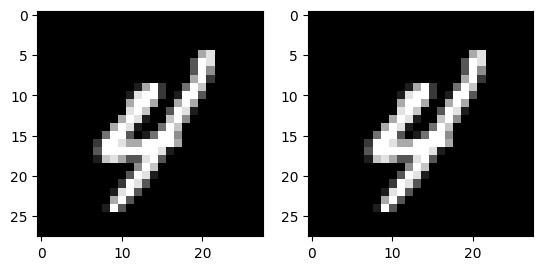

In [4]:
np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

X, y = reduce_dataset(X, y, 100)

# plot_class_distribution(y)
fig, ax = plt.subplots(1,2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777)
print(X_train[7])
ax[0].imshow(X_train[7], cmap = 'gray')

# Prereprocessing
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0], -1)

print("X train shape", X_train.shape)
print("y train shape", y_train.shape)
print("X test shape", X_test.shape)
print("y test shape", y_test.shape)
print(X_train[7].reshape(28,28))
ax[1].imshow(X_train[7].reshape(28,28), cmap = 'gray')


# Простой 3-х слойный персептрон
### Архитектура
#### Input ► Dense-300 ► Dense-100 ► Output 
* Lr = 0.0001
* batch_size = 64
* epochs = 29
* Accuracy: 0.96
* F1 w avg: 0.96

Epoch:   0%|          | 0/29 [00:00<?, ?it/s]

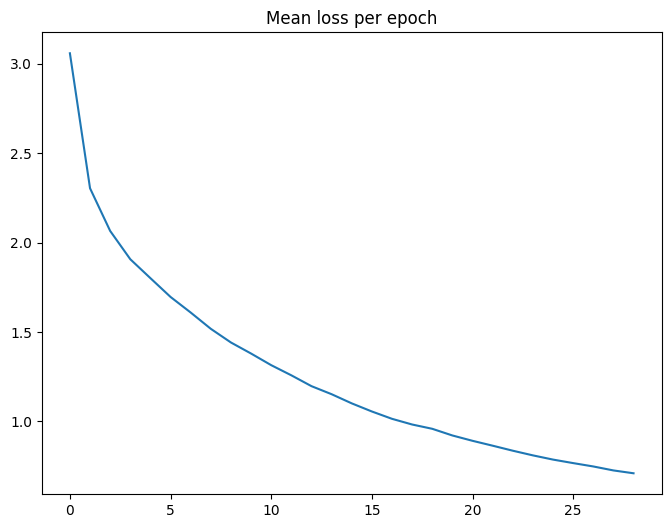

In [5]:
simple_3L_network = NerualNetworkBase(
  [Dense(28*28, 300), ReLU(), Dense(300, 100), ReLU(), Dense(100,10)],
  CrossEntropyLoss  
) 

simple_3L_network.train(
    X_train,
    y_train,
    batch_size=64,
    learning_rate=0.0001,
    epochs=29)

simple_3L_network.show_loss()

In [6]:
predictions = [
    np.argmax(simple_3L_network.predict(x)) for x in X_test]
print(classification_report([np.argmax(y) for y in y_test], predictions))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.92      0.96      0.94        23
           2       0.83      0.86      0.84        22
           3       0.83      0.76      0.79        25
           4       0.76      0.81      0.79        16
           5       0.93      0.61      0.74        23
           6       0.95      0.95      0.95        20
           7       0.63      1.00      0.77        12
           8       0.69      0.79      0.73        14
           9       0.75      0.75      0.75        20

    accuracy                           0.83       200
   macro avg       0.82      0.84      0.82       200
weighted avg       0.84      0.83      0.83       200



Answer:  6


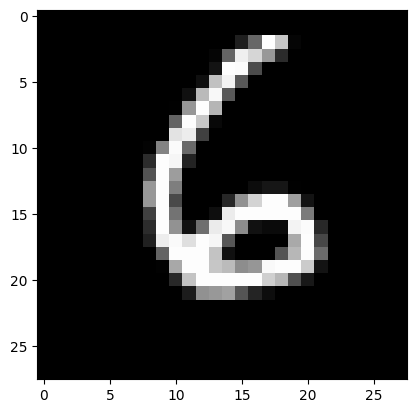

In [7]:
i = np.random.randint(0, len(X_test))
print("Answer: ", np.argmax(simple_3L_network.predict(X_test[i])))
plt.imshow(X_test[i].reshape(28, 28), cmap = 'gray')
plt.show()

# LeNet 

In [11]:
# lenet5 = NerualNetworkBase(
#     [
#         Conv(1, 6, 5),
#         ReLU(), 
#         MaxPool(2,2), 
#         Conv(6, 16, 5), 
#         ReLU(), 
#         MaxPool(2,2), 
#         Reshape((-1, 16, 4, 4), (-1, 16*4*4)),
#         Dense(16*4*4, 120), 
#         ReLU(), 
#         Dense(120, 84), 
#         ReLU(), 
#         Dense(84, 10), 
#         ],
#     CrossEntropyLoss
# )

lenet5 = NerualNetworkBase(
    [
        Conv(1,6,5),
        ReLU(),
        # MaxPool(2,2),
        Reshape((-1, 6,24,24), (-1,6*24*24)),
        Dense(6*24*24, 120),
        ReLU(),
        Dense(120,10)
    ],
    CrossEntropyLoss
)

lenet5.train(X_train, y_train, batch_size=256, learning_rate=10e-2, epochs=29, )
lenet5.show_loss()



Epoch:   0%|          | 0/29 [00:00<?, ?it/s]

ValueError: cannot reshape array of size 110592 into shape (256,3456)

In [ ]:
pred = lenet5.predict(X_test)
predictions = [np.argmax(pred[i]) for i in range(len(pred))]
print(classification_report([np.argmax(y) for y in y_test], predictions))

              precision    recall  f1-score   support

           0       0.12      1.00      0.22        25
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        20

    accuracy                           0.12       200
   macro avg       0.01      0.10      0.02       200
weighted avg       0.02      0.12      0.03       200



c:\Users\ivanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ivanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ivanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
pred

array([[0.132, 0.093, 0.09 , ..., 0.118, 0.098, 0.118],
       [0.132, 0.093, 0.09 , ..., 0.118, 0.098, 0.118],
       [0.132, 0.093, 0.09 , ..., 0.118, 0.098, 0.118],
       ...,
       [0.132, 0.093, 0.09 , ..., 0.118, 0.098, 0.118],
       [0.132, 0.093, 0.09 , ..., 0.118, 0.098, 0.118],
       [0.132, 0.093, 0.09 , ..., 0.118, 0.098, 0.118]])